# Extreme Gradient Boosting Classification
### Необходимые пакеты

In [1]:
import warnings 
import numpy as np 
import pandas as pd
import seaborn as se  
import plotly as ply
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,plot_confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report
warnings.filterwarnings('ignore')
%matplotlib inline
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Инициализация

Filepath of CSV file

In [2]:
#filepath
file_path= "telco-customer-churn.csv"

### Выборка данных

Pandas - это библиотека с открытым исходным кодом и лицензией BSD, предоставляющая высокопроизводительные, простые в использовании инструменты для манипулирования данными и анализа данных.

Мы будем использовать библиотеку Pandas для чтения CSV-файла, используя его путь хранения. И мы используем функцию head для отображения начальной строки или записи.

In [3]:
df=pd.read_csv(file_path)
df.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

In [45]:
df.nunique()

age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
noadditionallines                          1
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
occupation                                 3
penaltytoswitch                          500
state                                     50
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoices

In [44]:
info

### Отбор признаков

Это процесс сокращения числа входных переменных при разработке прогностической модели. Используется для уменьшения числа входных переменных как для снижения вычислительных затрат на моделирование, так и, в некоторых случаях, для повышения эффективности модели.

Назначим все необходимые входные признаки на X, а цель/результат - на Y.


In [14]:
X = df.drop(['churn', 'year', 'month', 'callingnum'],axis=1)
Y = df.churn

Поиск баланса меток в наборе данных

In [13]:
print('Labels: {}'.format(set(Y)))
print('Zero count = {}, One count = {}'.format(len(Y) - sum(Y), sum(Y)))

Labels: {0, 1}
Zero count = 18605, One count = 1863


Декларация категориальных признаков

In [15]:
categorical_columns = list(X.select_dtypes(include=['object']).columns.values.tolist())

### Предварительная обработка данных

Поскольку большинство моделей машинного обучения в библиотеке Sklearn не обрабатывают строковые значениия и NaN-значения, нам приходится явно удалять или заменять NaN-значения. В приведенном ниже фрагменте есть функции, которые удаляют нулевое значение, если таковое существует. И преобразуют данные строковых классов в наборе данных, кодируя их в целочисленные классы.

In [10]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)
def EncodeY(df):
    if len(df.unique())<=2:
        return df
    else:
        un_EncodedT=np.sort(pd.unique(df), axis=-1, kind='mergesort')
        df=LabelEncoder().fit_transform(df)
        EncodedT=[xi for xi in range(len(un_EncodedT))]
        print("Encoded Target: {} to {}".format(un_EncodedT,EncodedT))
        return df

In [11]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
Y=EncodeY(NullClearner(Y))
X.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,usesinternetservice_No,usesinternetservice_Yes,usesvoiceservice_No,usesvoiceservice_Yes
0,12,168147,0.06,0.00,4251078442,1,71,0,7,96,...,0,0,1,0,0,0,1,0,1,0
1,12,168147,0.06,0.00,4251078442,1,71,0,7,96,...,0,0,1,0,0,0,1,0,1,0
2,42,29047,0.05,0.01,4251043419,2,8,1,4,14,...,0,0,0,1,0,0,1,0,0,1
3,42,29047,0.05,0.01,4251043419,2,8,1,4,14,...,0,0,0,1,0,0,1,0,0,1
4,58,27076,0.07,0.02,4251055773,3,16,0,2,55,...,0,0,0,0,0,0,1,0,1,0


#### Распределение целевой переменной

<AxesSubplot:xlabel='churn', ylabel='count'>

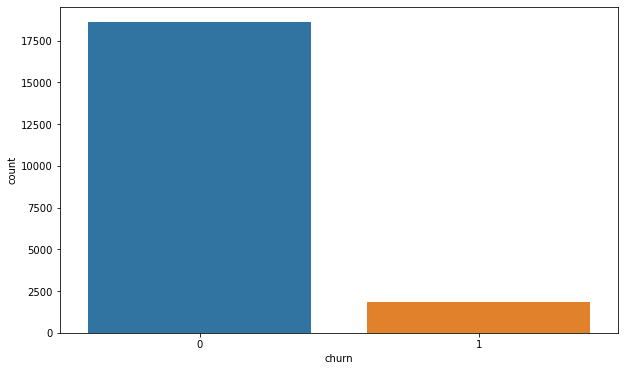

In [35]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Разделение данных

Разделение данных на тренировочные и тестовые - это процедура оценки эффективности алгоритма. Процедура включает в себя взятие набора данных и разделение его на два подмножества. Первое подмножество используется для подгонки/обучения модели. Второе подмножество используется для прогнозирования. Основным мотивом является оценка эффективности модели на новых данных.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 12, stratify=Y)

### Модель

XGBoost - это оптимизированная распределенная библиотека градиентного бустинга, разработанная для обеспечения высокой эффективности, гибкости и переносимости. Она реализует алгоритмы машинного обучения в рамках градиентного бустинга. XGBoost обеспечивает параллельный древовидный бустинг (также известный как GBDT, GBM), который быстро и точно решает многие проблемы науки о данных.

Параметры настройки подробно описаны в официальной документации API  [Tunning Parameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) 

In [24]:
cat_df = df.drop(['year', 'month', 'callingnum'],axis=1)
cat_df

,age,annualincome,calldroprate,callfailurerate,customerid,customersuspended,education,gender,homeowner,maritalstatus,...,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn
0,12,168147,0.06,0.00,1,Yes,Bachelor or equivalent,Male,Yes,Single,...,371,WA,15,19,No,No,0.82,5971,663,0
1,12,168147,0.06,0.00,1,Yes,Bachelor or equivalent,Male,Yes,Single,...,371,WA,15,19,No,No,0.82,3981,995,0
2,42,29047,0.05,0.01,2,Yes,Bachelor or equivalent,Female,Yes,Single,...,43,WI,212,34,No,Yes,0.27,7379,737,0
3,42,29047,0.05,0.01,2,Yes,Bachelor or equivalent,Female,Yes,Single,...,43,WI,212,34,No,Yes,0.27,1729,432,0
4,58,27076,0.07,0.02,3,Yes,Master or equivalent,Female,Yes,Single,...,403,KS,216,144,No,No,0.48,3122,624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20463,33,67056,0.07,0.00,9523,Yes,Bachelor or equivalent,Male,Yes,Married,...,395,AR,249,172,No,No,0.38,7651,850,1
20464,49,65084,0.01,0.01,9524,Yes,Master or equivalent,Female,Yes,Single,...,255,MD,252,32,No,No,0.59,3241,648,0
20465,49,65084,0.01,0.01,9524,Yes,Master or equivalent,Female,Yes,Single,...,255,MD,252,32,No,No,0.59,5034,719,0
20466,51,120042,0.05,0.01,9525,Yes,Master or equivalent,Male,No,Married,...,432,IL,351,67,No,No,0.12,7200,720,0


In [26]:
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(df):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
create_cd(
    label=-1, 
    cat_features=list(X.select_dtypes(include=['object']).columns.values.tolist()),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

NameError: name 'os' is not defined

In [17]:
model = CatBoostClassifier(silent=True, class_weights = [0.1, 0.9])
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          use_best_model=True,
    
          cat_features=categorical_columns)
y_pred = model.predict(X_test)

KeyboardInterrupt: 

In [18]:
cat = CatBoostClassifier(eval_metric='Accuracy', class_weights = [0.1, 0.9])
cat.fit(X_train,y_train,verbose=False, plot=True, cat_features=categorical_columns)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
cat.plot_tree(tree_idx=0)

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tree_print.cpp:213: Please pass training dataset to plot_tree function, training dataset is required if categorical features are present in the model.

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score



accuracy_score = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
roc_auc_score = roc_auc_score(y_test, y_pred)



In [45]:
print('Accuracy:', accuracy_score)
print('Precision:', precision_score)
print('Recall:', recall_score)
print('ROC/AUC:', roc_auc_score)


Accuracy: 0.9508223416381697
Precision: 0.9961389961389961
Recall: 0.46153846153846156
ROC/AUC: 0.7306796571397074


In [16]:
def model_building(model):
    your_model=model
    your_model.fit(X_train,y_train)
    pred=your_model.predict(X_test)
    print("Accuracy of {0} : {1}".format(str(model)[:],accuracy_score(y_test,pred)))
    print("AUC :",roc_auc_score(y_test,pred))

model_building(CatBoostClassifier(eval_metric='AUC'))



CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=6]="Yes": Cannot convert 'b'Yes'' to float

In [68]:
xgb_params = {'n_estimators': range(10, 50, 10),
              'eta': np.arange(0.1, 1., .2),
              'min_child_weight': range(1, 10, 2),
              'subsample': np.arange(0.1, 1., 0.2)}

In [69]:
xgb = XGBClassifier(random_state=123,n_jobs=-1)

model = GridSearchCV(xgb, xgb_params, cv=5, refit=True, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)
model_best = model.best_estimator_
print("Stacking Accuracy: {} with params {}"
      .format(model.best_score_, model.best_params_))

print(f'Accuracy valid: {accuracy_score(y_test, model.predict(X_test))}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


KeyboardInterrupt: 

In [30]:
param_grid = {
    'silent': [False],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1, 0.15, ],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 200],
    'n_estimators': [50, 100, 150],
    'scale_pos_weight': [1, 1.5, 2],
    'max_delta_step': [1, 2, 3]
}

clf = XGBClassifier(objective = 'binary:logistic', n_jobs = -1)

In [33]:
clf = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=123)
clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
        eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.73772
[1]	validation_0-auc:0.75443
[2]	validation_0-auc:0.78900
[3]	validation_0-auc:0.80005
[4]	validation_0-auc:0.81385
[5]	validation_0-auc:0.82390
[6]	validation_0-auc:0.82781
[7]	validation_0-auc:0.83842
[8]	validation_0-auc:0.84333
[9]	validation_0-auc:0.85106
[10]	validation_0-auc:0.85904
[11]	validation_0-auc:0.86671
[12]	validation_0-auc:0.87427
[13]	validation_0-auc:0.87606
[14]	validation_0-auc:0.88325
[15]	validation_0-auc:0.88252
[16]	validation_0-auc:0.88650
[17]	validation_0-auc:0.89039
[18]	validation_0-auc:0.89679
[19]	validation_0-auc:0.89570
[20]	validation_0-auc:0.90003
[21]	validation_0-auc:0.90081
[22]	validation_0-auc:0.90425
[23]	validation_0-auc:0.90693
[24]	validation_0-auc:0.90749
[25]	validation_0-auc:0.91016
[26]	validation_0-auc:0.91708
[27]	validation_0-auc:0.91965
[28]	validation_0-auc:0.91937
[29]	validation_0-auc:0.91814
[30]	validation_0-auc:0.91980
[31]	validation_0-auc:0.92463
[32]	validation_0-auc:0.92767
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [19]:
param_grid = { 
    'max_depth': [3, 4, 5], 
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0,25, 1],
    'reg_lambda': [0, 1, 10,],
    'scale_pos_weight': [1, 3, 5]
}

In [22]:
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
                              param_grid = param_grid, scoring = 'roc_auc', verbose = 0, n_jobs = -1, cv = 3)

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [25]:
optimal_params

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=0.9, tree_metho

In [26]:
optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}


In [27]:
clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', gamma=.25, learing_rate=0.1, max_depth=4, 
                        reg_lambda=10, scale_pos_weight=3, subsample=0.9, colsample_bytree=0.5)

clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[01:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.13144
[1]	validation_0-aucpr:0.17578
[2]	validation_0-aucpr:0.18022
[3]	validation_0-aucpr:0.16617
[4]	validation_0-aucpr:0.17007
[5]	validation_0-aucpr:0.18848
[6]	validation_0-aucpr:0.19752
[7]	validation_0-aucpr:0.19055
[8]	validation_0-aucpr:0.22568
[9]	validation_0-aucpr:0.23301
[10]	validation_0-aucpr:0.24272
[11]	validation_0-aucpr:0.25478
[12]	validation_0-aucpr:0.25922
[13]	validation_0-aucpr:0.26057
[14]	validation_0-aucpr:0.26153
[15]	validation_0-aucpr:0.26162
[16]	validation_0-aucpr:0.26963
[17]	validation_0-aucpr:0.28201
[18]	validation_0-aucpr:0.28518
[19]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learing_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### Точность модели

Метод score() возвращает среднюю точность на заданных тестовых данных и метках.

В классификации это точность подмножества, которая является жесткой метрикой, поскольку для каждой выборки требуется, чтобы каждый набор меток был правильно предсказан.


In [19]:
print("Accuracy score {:.2f} %\n".format(cat.score(X_test,y_test)*100))

Accuracy score 94.45 %



#### Матрица ошибок

Матрица смешения используется для понимания производительности модели классификации или алгоритма в машинном обучении для заданного тестового набора, результаты которого известны.

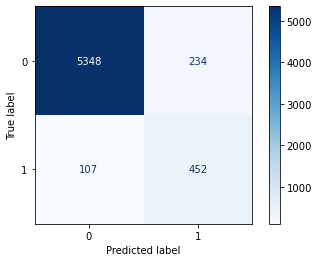

In [21]:
plot_confusion_matrix(cat,X_test,y_test,cmap=plt.cm.Blues)

#### Отчет о классификации

Отчет о классификации используется для измерения качества предсказаний алгоритма классификации. Сколько предсказаний являются истинными, сколько - ложными.

* **где:**:
    - Precision:- Точность положительных предсказаний.
    - Recall:- доля положительных прогнозов, которые были определены правильно.
    - f1-score:-  процент правильных положительных предсказаний.
    - support:- поддержка - это количество фактических вхождений класса в заданный набор данных.

In [17]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3734
           1       0.98      0.50      0.66       360

    accuracy                           0.96      4094
   macro avg       0.97      0.75      0.82      4094
weighted avg       0.96      0.96      0.95      4094



#### Важность признаков.¶

Важность признаков относится к техникам, которые присваивают признакам баллы в зависимости от того, насколько они полезны для составления прогноза.

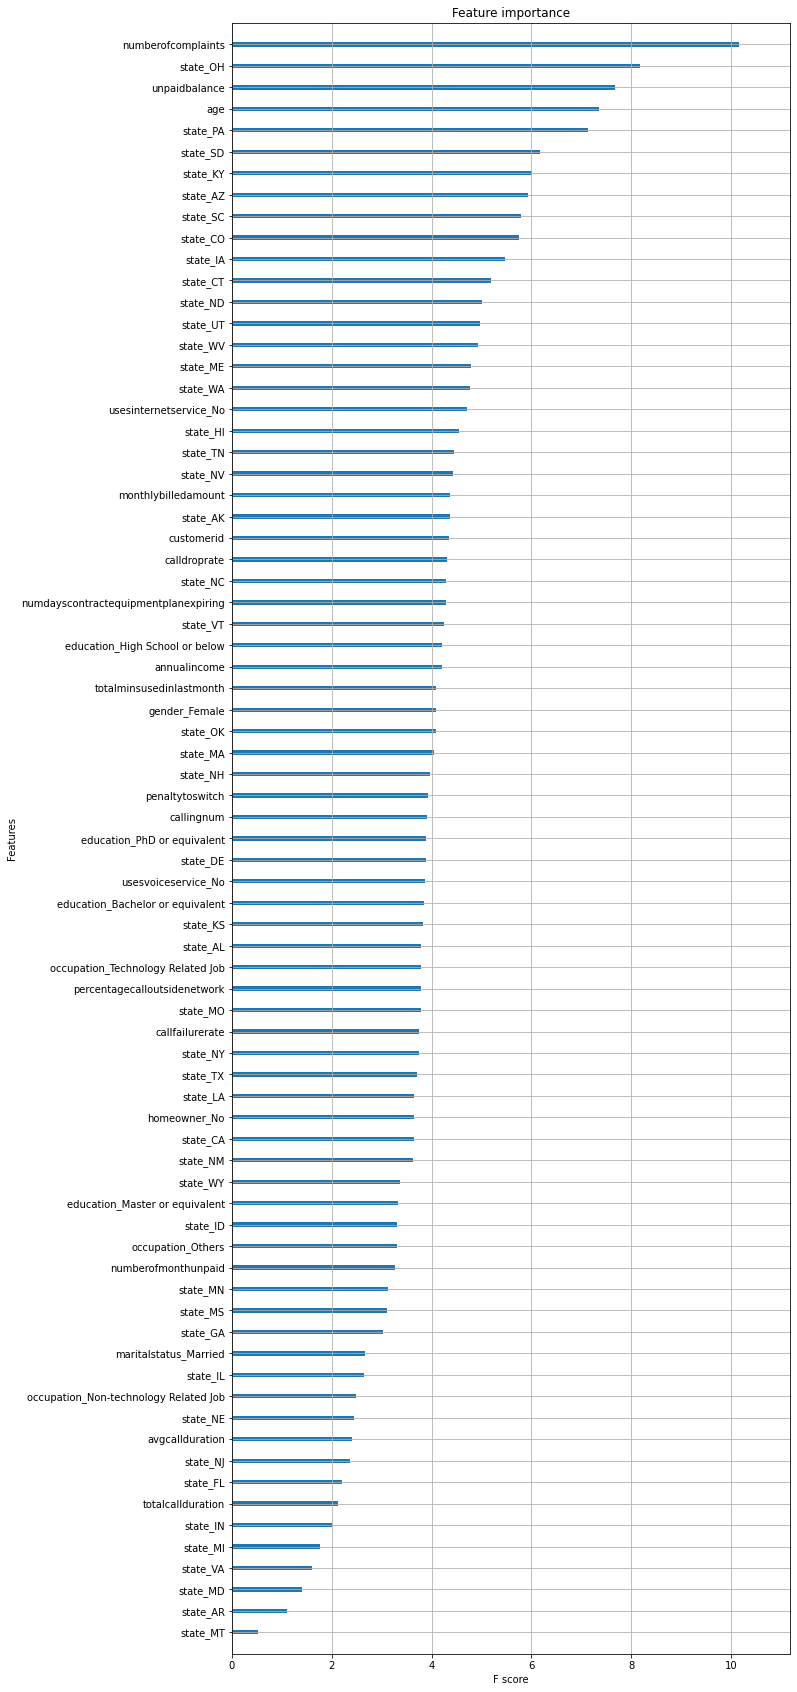

In [21]:
xgb.plot_importance(model,importance_type="gain",show_values=False)
plt.rcParams['figure.figsize'] = [15, 40]
plt.show()

#### Creator: Thilakraj Devadiga , Github: [Profile](https://github.com/Thilakraj1998)